# Tutorial 2

Annotate and evaluate seqfish data with novel cell detection. 

In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np

# read h5ad rna/seqfish data
device = torch.device('cuda:2')
adata_rna = sc.read_h5ad('/data/msyuan/Cross-omics-Annotator/SPANN_Package/sample_data/adata_rna.h5ad')
adata_seqfish = sc.read_h5ad('/data/msyuan/Cross-omics-Annotator/SPANN_Package/sample_data/adata_seqfish_40.h5ad')

# compute common cell type and novel cell type
common_cell_type = [i for i in np.unique(adata_rna.obs['cell_type']) if i in np.unique(adata_seqfish.obs['cell_type'])]
novel_cell_type = [i for i in np.unique(adata_seqfish.obs['cell_type']) if i not in np.unique(adata_rna.obs['cell_type'])]
cell_types = common_cell_type + novel_cell_type

In [2]:
# preprocess to get torch datasets and dataloaders
from preprocess import *

adata_cm, adata_spa, adata_rna = anndata_preprocess(adata_seqfish, adata_rna, spatial_labels=True)
source_sp_ds,target_sp_ds,source_cm_dl,target_cm_dl,test_source_cm_dl,test_target_cm_dl = generate_dataloaders(adata_cm,adata_spa,adata_rna)

/data/msyuan/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


rna_labels: [ 0  1  2  3  4  5  6  7  8  9 10]
spatial_labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [3]:
# contruct SPANN model
from model import *

enc,dec,x_dim,z_dim = generate_ae_params(adata_cm, adata_spa, adata_rna)
spann = SPANN_model(x_dim, z_dim, enc, dec, class_num=len(adata_rna.obs['cell_type'].unique()), device=device)

[easydl] tensorflow not available!


In [5]:
# train SPANN model with validation

source_sp_ds,target_sp_ds,source_cm_dl,target_cm_dl,\
test_source_cm_dl,test_target_cm_dl = generate_dataloaders(adata_cm,adata_spa,adata_rna,batch_size=256)
adata_source, adata_target, threshold_test = spann.train_eval(source_cm_dl,target_cm_dl,source_sp_ds,target_sp_ds,adata_spa.obs[["X","Y"]],
                                                              test_source_cm_dl, test_target_cm_dl,np.array(adata_rna.obs['labels']),
                                                              np.array(adata_seqfish.obs['labels']),cell_types, common_cell_type,
                                                              lr=2e-4,resolution=0.5,lambda_spa=0.001,lambda_cd=0.0001,lambda_nb=10,
                                                              maxiter=5000,miditer1=2000,miditer2=4000,miditer3=4000)

#Iter 100: Reconstruction loss: 2.257686, KL loss: 88.931099, CLS loss: 1.407960, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 200: Reconstruction loss: 2.172615, KL loss: 84.677094, CLS loss: 1.368390, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 300: Reconstruction loss: 2.154573, KL loss: 66.177856, CLS loss: 1.151969, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 400: Reconstruction loss: 2.112775, KL loss: 82.911514, CLS loss: 1.001163, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 500: Reconstruction loss: 2.070595, KL loss: 96.194229, CLS loss: 1.123448, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 600: Reconstruction loss: 2.040261, KL loss: 77.606903, CLS loss: 0.955164, Spatial loss: 0.000000, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 700: Reconstruction loss: 2.024984, KL loss: 71.032997, CLS loss: 0.848757, Spatial loss: 0.00

#Iter 4800: Reconstruction loss: 1.181943, KL loss: 35.322384, CLS loss: 0.626009, Spatial loss: 0.085399, CCD loss: 0.231927, Neighbor loss: 0.008081
#Iter 4900: Reconstruction loss: 1.169745, KL loss: 34.970551, CLS loss: 0.639672, Spatial loss: 0.077415, CCD loss: 0.172733, Neighbor loss: 0.010397
#Iter 5000: Reconstruction loss: 1.154006, KL loss: 34.661934, CLS loss: 0.652082, Spatial loss: 0.087333, CCD loss: 0.178229, Neighbor loss: 0.008427
#Iter 5000: (OT) Source acc: 0.772237, Target total acc : 0.645488,  Target known acc: 0.618334, Target unknown acc: 0.680353
#Iter 5000: (CLS) Source acc: 0.944456, Target total acc : 0.654238,  Target known acc: 0.633900, Target unknown acc: 0.680353
#Iter 5100: Reconstruction loss: 1.145890, KL loss: 34.078972, CLS loss: 0.641034, Spatial loss: 0.083072, CCD loss: 0.170831, Neighbor loss: 0.010245


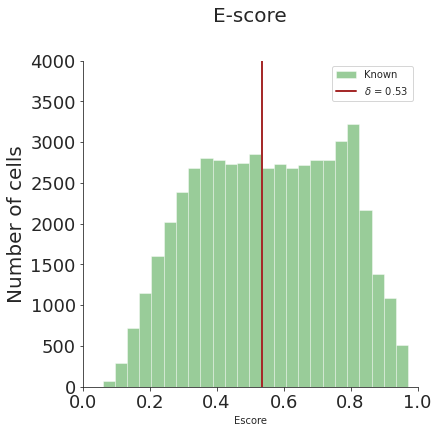

In [6]:
# distribution plot
from functions import *

dist_fig = distribution_plot(adata_target.obs['Escore'], threshold_test, bins=25, ylim=4000)

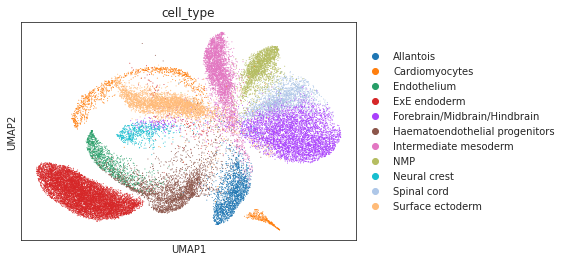

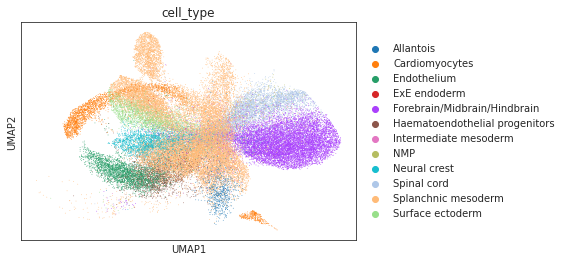

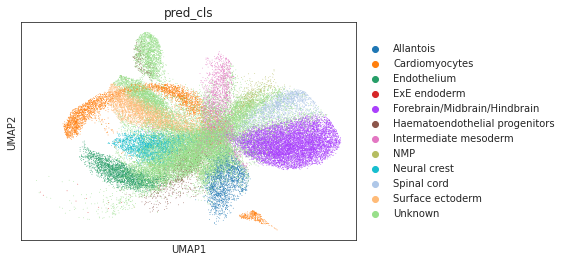

In [8]:
# umap visualizations
# umap plot colored by source and cell types

adata_total = sc.AnnData.concatenate(adata_source, adata_target)
sc.pp.neighbors(adata_total, use_rep="X")
sc.tl.umap(adata_total)
sc.pl.umap(adata_total, color="source", show=True)
sc.pl.umap(adata_total[adata_total.obs['source']=='scRNA'], color="cell_type", show=True)
sc.pl.umap(adata_total[adata_total.obs['source']=='Spatial'], color="cell_type", show=True)
sc.pl.umap(adata_total[adata_total.obs['source']=='Spatial'], color="pred_cls", show=True)

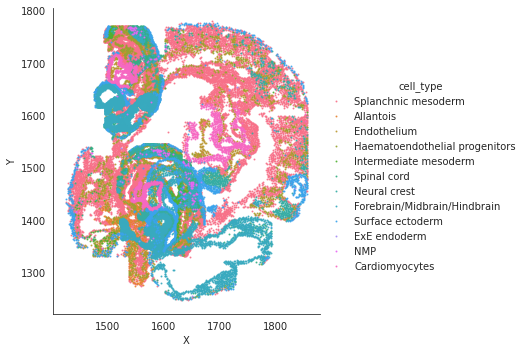

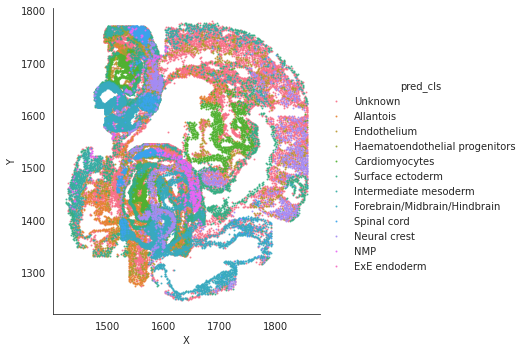

In [9]:
# spatial plot 
import seaborn as sns

sns.lmplot(data=adata_target.obs, x='X', y='Y',hue='cell_type',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})
sns.lmplot(data=adata_target.obs, x='X', y='Y',hue='pred_cls',fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})